In [ ]:
cd drive/MyDrive/deeplearningprojects/xray(CNN)/

In [ ]:
ls

In [ ]:
import zipfile
import os
import cv2
from keras.models import load_model
import numpy
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import RMSprop, Adam,SGD
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau






Extracting Zipfile

In [ ]:
#with zipfile.ZipFile("/content/drive/MyDrive/deeplearningprojects/xray(CNN)/xray.zip")as file:
  #file.extractall("")

Listing Directories

In [ ]:
train_path=os.listdir("/content/drive/MyDrive/deeplearningprojects/xray(CNN)/chest_xray/train/")
normal_data=os.listdir("/content/drive/MyDrive/deeplearningprojects/xray(CNN)/chest_xray/train/NORMAL/")
pneumonia_data=os.listdir("/content/drive/MyDrive/deeplearningprojects/xray(CNN)/chest_xray/train/PNEUMONIA/")

In [ ]:
print(len(normal_data))
print(len(pneumonia_data))

1342
3876


observation data points are imbalanced

In [ ]:
train_data_dir = '/content/drive/MyDrive/deeplearningprojects/xray(CNN)/chest_xray/train'
validation_data_dir = '/content/drive/MyDrive/deeplearningprojects/xray(CNN)/chest_xray/val/'
test_data_dir="/content/drive/MyDrive/deeplearningprojects/xray(CNN)/chest_xray/test/"

In [ ]:
batch_size = 16

Preparing Input Data

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   validation_split = 0.1)
test_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:

train_dataset = train_datagen.flow_from_directory(
              train_data_dir,
                target_size = (224,224),
                class_mode = 'categorical',
                batch_size = batch_size,
                shuffle = True
                )

validation_dataset = train_datagen.flow_from_directory(
                validation_data_dir,
                target_size = (224,224),
                class_mode = 'categorical',
                batch_size = batch_size,
                shuffle = True
                )

test_dataset = test_datagen.flow_from_directory(
               test_data_dir,
                target_size = (224,224),
                class_mode = 'categorical',
                batch_size = batch_size,
                shuffle = True
                )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Model Architecture

The architecture of MobileNetV2 contains the initial fully convolution layer with 32 filters, followed by 19 residual bottleneck layers. The researchers have tailored the architecture to different performance points, by using the input image resolution and width multiplier as tunable hyperparameters, that can be adjusted depending on desired accuracy or performance trade-offs. The primary network  (width multiplier 1, 224 × 224), has a computational cost of 300 million multiply-adds and uses 3.4 million parameters. The network computational cost ranges from 7 multiply-adds to 585M MAdds, while the model size varies between 1.7M and 6.9M parameters.

# Model built using transfer learning


In [ ]:
# MobileNet is designed to work with images of dim 224,224
img_rows, img_cols = 224,224
MobileNet = MobileNetV2(weights='imagenet',include_top=False,input_shape=(img_rows,img_cols,3))

In [ ]:
for layer in MobileNet.layers:
    layer.trainable = False

In [ ]:
model = Sequential()
model.add(MobileNet)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation= 'relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_21  (None, 1280)              0         
_________________________________________________________________
dense_86 (Dense)             (None, 256)               327936    
_________________________________________________________________
dropout_56 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 32)                8224      
_________________________________________________________________
dropout_57 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_88 (Dense)             (None, 32)              

In [ ]:
model.save("chest.h5")

In [ ]:
checkpoint = ModelCheckpoint('chest.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0001)
callbacks = [earlystop,checkpoint,learning_rate_reduction]

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
epochs =10
batch_size =20

history = model.fit(
            train_dataset,
            steps_per_epoch=35,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=validation_dataset 
            )

Epoch 1/10
35/35 [==============================] - 10s 215ms/step - loss: 0.8557 - accuracy: 0.6628 - val_loss: 0.5237 - val_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 0.52373, saving model to chest.h5
Epoch 2/10
35/35 [==============================] - 7s 189ms/step - loss: 0.4939 - accuracy: 0.7310 - val_loss: 0.5277 - val_accuracy: 0.5000

Epoch 00002: val_loss did not improve from 0.52373
Epoch 3/10
35/35 [==============================] - 7s 193ms/step - loss: 0.4425 - accuracy: 0.7764 - val_loss: 0.4844 - val_accuracy: 0.5625

Epoch 00003: val_loss improved from 0.52373 to 0.48439, saving model to chest.h5
Epoch 4/10
35/35 [==============================] - 6s 184ms/step - loss: 0.3385 - accuracy: 0.8279 - val_loss: 0.3759 - val_accuracy: 0.8750

Epoch 00004: val_loss improved from 0.48439 to 0.37594, saving model to chest.h5
Epoch 5/10
35/35 [==============================] - 7s 187ms/step - loss: 0.3061 - accuracy: 0.8482 - val_loss: 0.4829 - val_accuracy: 0.

In [ ]:
label={0:'NORMAL',1:'PNEUMONIA'}


In [ ]:
model.save("chest.h5")

Evaluate model

In [ ]:
model.evaluate(test_dataset)

39/39 [==============================] - 6s 159ms/step - loss: 0.5622 - accuracy: 0.8221


[0.5621963739395142, 0.8221153616905212]

In [ ]:
model=load_model("chest.h5")

IMAGE-3(xray) prediction

In [ ]:
i3=cv2.imread("/content/image.jpg",0)
i3.shape

(209, 241)

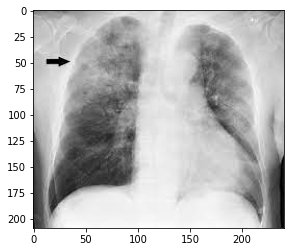

In [ ]:
plt.imshow(i3,cmap='gray')

In [ ]:
imagec=np.resize(i3,new_shape=(224,224,3))
image3 = imagec.reshape(1,224,224,3)
image3.shape

(1, 224, 224, 3)

In [ ]:
label[model.predict_classes(image3)[0]]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'PNEUMONIA'

IMAGE-4(xray) prediction

In [ ]:
i4=cv2.imread("np4.jpg",0)
i3.shape

(209, 241)

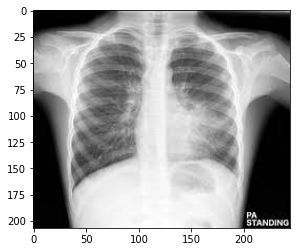

In [ ]:
plt.imshow(i4,cmap='gray')

In [ ]:
imaged=np.resize(i4,new_shape=(224,224,3))
image4 = imaged.reshape(1,224,224,3)
image4.shape

(1, 224, 224, 3)

In [ ]:
label[model.predict_classes(image4)[0]]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


'PNEUMONIA'